# **DATA SCIENCE FINAL PROJECT**
# **ANALYZING MACHINE LEARNING MODELS FOR PREDICTING POWER CONSUMPTION: CASE OF STUDY IN TETUAN CITY**

The primary objective of this work is to develop and evaluate predictive models for forecasting energy consumption in Tetuan City, enhancing the accuracy and reliability of predictions to support effective energy management and planning. In this study we focus on answering two main questions:

* How do time-based features impact the accuracy of energy consumption forecasts in Tetuan City?
	
* Which machine learning model (XGBoost, Random Forest, or LSTM) provides the most accurate predictions for short-term energy consumption in Tetuan City?

By leveraging machine learning techniques, we aim to enhance the accuracy and reliability of energy demand forecasts, which are crucial for effective energy management and planning in the face of rising global energy demands and climate change.

# 1. IMPORT PACKAGE

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV, train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose


# 2. DATA DESCRIPTION

The dataset used in this study is sourced from the UCI Machine Learning Repository [UCI Machine Learning Repository: Tetuan City Power Consumption Dataset](https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city)

## 2.1. Data Upload

In [2]:
notebook_dir=os.getcwd()
file_path = os.path.join(notebook_dir, 'Tetuan_City_power_consumption.csv')
data = pd.read_csv(file_path)

## 2.2. Data Cleaning

In [3]:
#Change format of the dataset
data['DateTime']=pd.to_datetime(data['DateTime'],format='%m/%d/%Y %H:%M')
data.set_index('DateTime',inplace=True)

#Rename columns
column_mapping = {
    'Temperature': 'temperature',
    'Humidity': 'humidity',
    'Wind Speed': 'wind_speed',
    'general diffuse flows': 'general_diffuse_flows',
    'diffuse flows': 'diffuse_flows',
    'Zone 1 Power Consumption': 'zone_1_power_consumption',
    'Zone 2  Power Consumption': 'zone_2_power_consumption',
    'Zone 3  Power Consumption': 'zone_3_power_consumption'
}

data.rename(columns=column_mapping,inplace=True)

# Handle missing values
data = data.fillna(data.mean())

# Normalize features
features_to_scale = ['temperature', 'humidity', 'wind_speed', 'general_diffuse_flows', 'diffuse_flows']
scaler = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

#Save clean data
output_dir = os.path.join(notebook_dir)
output_file_path = os.path.join(output_dir, 'Tetuan_City_power_consumption_cleaned.csv')
data.to_csv(output_file_path, index=False)
print(f"Preprocessed data saved to {output_file_path}")

Preprocessed data saved to /Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/ADA_FP/Tetuan_City_power_consumption_cleaned.csv


## 2.3. Feature Engineering

In [4]:
# Define our target variables
target=[ 'zone_1_power_consumption', 'zone_2_power_consumption',
       'zone_3_power_consumption']

# Add time-based and statistical features
def create_features(data):
    data=data.copy()
    
    data['hour']=data.index.hour
    data['dayofweek']=data.index.dayofweek
    data['quarter']=data.index.quarter
    data['month']=data.index.month
    data['year']=data.index.year
    data['dayofyear']=data.index.dayofyear
    data['day']=data.index.day
    data['is_weekend']=data.index.dayofweek >=5
    
    for zone in target:
           data[f'{zone}_lag_1']=data[zone].shift(1)
           data[f'{zone}_lag_2']=data[zone].shift(2)
           data[f'{zone}_rolling_mean_3']=data[zone].rolling(window=3).mean()
           data[f'{zone}_rolling_std_3']=data[zone].rolling(window=3).std()
           data[f'{zone}_ema_3']=data[zone].ewm(span=3,adjust=False).mean()
    return data

data=create_features(data)

# Define features
features=['temperature', 'humidity', 'wind_speed', 'general_diffuse_flows',
       'diffuse_flows','hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear','day', 'is_weekend',
       'zone_1_power_consumption_lag_1', 'zone_1_power_consumption_lag_2',
       'zone_1_power_consumption_rolling_mean_3','zone_1_power_consumption_rolling_std_3',
       'zone_1_power_consumption_ema_3',
       'zone_2_power_consumption_lag_1', 'zone_2_power_consumption_lag_2',
       'zone_2_power_consumption_rolling_mean_3', 'zone_2_power_consumption_rolling_std_3',
       'zone_2_power_consumption_ema_3', 
       'zone_3_power_consumption_lag_1','zone_3_power_consumption_lag_2',
       'zone_3_power_consumption_rolling_mean_3', 'zone_3_power_consumption_rolling_std_3',
       'zone_3_power_consumption_ema_3']

key_variables = ['temperature', 'humidity', 'wind_speed', 'general_diffuse_flows', 'diffuse_flows',
                 'zone_1_power_consumption', 'zone_2_power_consumption', 'zone_3_power_consumption']
data_key_vars = data[key_variables]


## 2.4. Statistics

In [5]:
data.describe()

,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,zone_1_power_consumption,zone_2_power_consumption,zone_3_power_consumption,hour,dayofweek,...,zone_2_power_consumption_lag_1,zone_2_power_consumption_lag_2,zone_2_power_consumption_rolling_mean_3,zone_2_power_consumption_rolling_std_3,zone_2_power_consumption_ema_3,zone_3_power_consumption_lag_1,zone_3_power_consumption_lag_2,zone_3_power_consumption_rolling_mean_3,zone_3_power_consumption_rolling_std_3,zone_3_power_consumption_ema_3
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,...,52415.000000,52414.000000,52414.000000,52414.000000,52416.000000,52415.000000,52414.000000,52414.000000,52414.000000,52416.000000
mean,0.423334,0.681998,0.296827,0.157088,0.080147,32344.970564,21042.509082,17835.406218,11.500000,3.000000,...,21042.451604,21042.381970,21042.520654,284.718255,21042.345665,17835.491879,17835.574355,17835.445621,268.549117,17835.532637
std,0.158188,0.186331,0.365127,0.227345,0.132706,7130.562564,5201.465892,6622.165099,6.922253,2.000019,...,5201.498865,5201.524054,5191.692217,268.447684,5177.995097,6622.199230,6622.235483,6613.647988,314.265524,6601.174559
min,0.000000,0.000000,0.000000,0.000000,0.000000,13895.696200,8560.081466,5935.174070,0.000000,0.000000,...,8560.081466,8560.081466,8615.071283,0.000000,8656.537318,5935.174070,5935.174070,6071.548619,0.000000,6143.974647
25%,0.303648,0.562785,0.004353,0.000050,0.000119,26310.668692,16980.766032,13129.326630,5.750000,1.000000,...,16980.676665,16980.587298,16990.852391,113.475470,16999.860935,13129.326630,13129.326630,13128.753797,89.464651,13126.720376
50%,0.422517,0.701174,0.005596,0.004326,0.004749,32265.920340,20823.168405,16415.117470,11.500000,3.000000,...,20823.100300,20823.100300,20824.316110,210.993921,20826.750298,16415.117470,16415.962095,16414.885953,173.267845,16421.644225
75%,0.534314,0.839444,0.756257,0.274804,0.107895,37309.018185,24713.717520,21624.100420,17.250000,5.000000,...,24713.921530,24714.125540,24714.760913,378.040660,24711.016512,21624.100420,21624.100420,21631.801628,325.476913,21620.914566
max,1.000000,1.000000,1.000000,1.000000,1.000000,52204.395120,37408.860760,47598.326360,23.000000,6.000000,...,37408.860760,37408.860760,36424.498417,4399.810487,36346.494997,47598.326360,47598.326360,47509.958160,5130.182272,47224.808643


# 3. DATA VISUALIZATION

In [6]:
sns.set_theme(style='whitegrid')
consumption_data = data[['zone_1_power_consumption', 'zone_2_power_consumption', 'zone_3_power_consumption']]

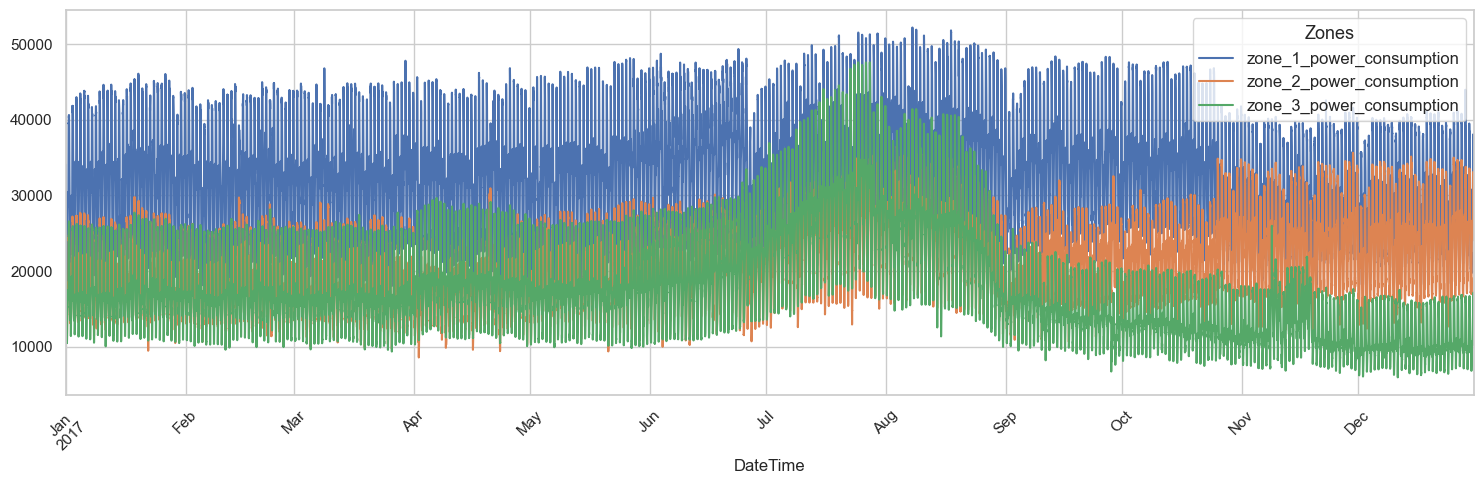

In [7]:
consumption_data.plot(figsize=(15,5))
plt.legend(title='Zones',fontsize=12,title_fontsize='13')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

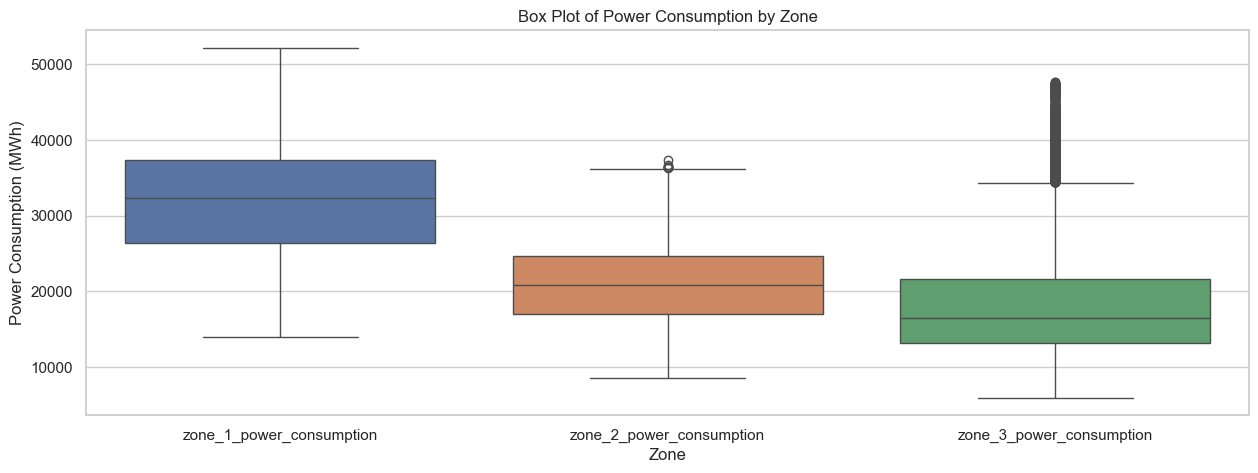

In [8]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=consumption_data)
plt.title('Box Plot of Power Consumption by Zone')
plt.xlabel('Zone')
plt.ylabel('Power Consumption (MWh)')
plt.show()

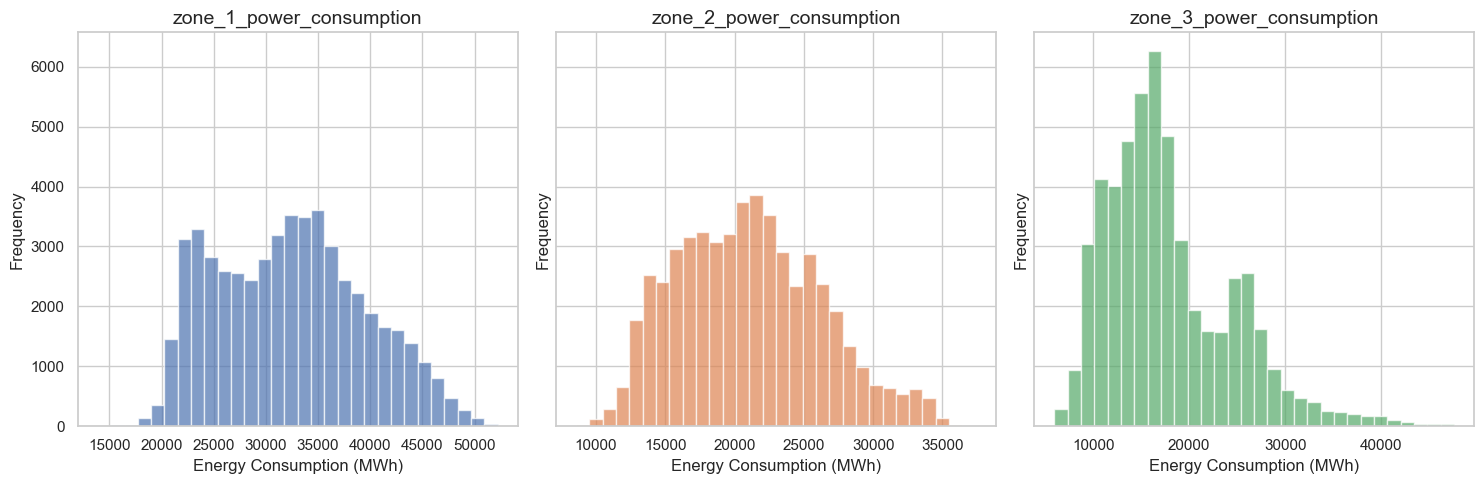

In [9]:
fig,axs=plt.subplots(1,3,figsize=(15,5),sharey=True)
for i,zone in enumerate(target):
    axs[i].hist(consumption_data[zone],bins=30,color=sns.color_palette()[i],alpha=0.7)
    axs[i].set_title(f'{zone}',fontsize=14)
    axs[i].set_xlabel('Energy Consumption (MWh)', fontsize=12)
    axs[i].set_ylabel('Frequency',fontsize=12)
plt.tight_layout()
plt.show()

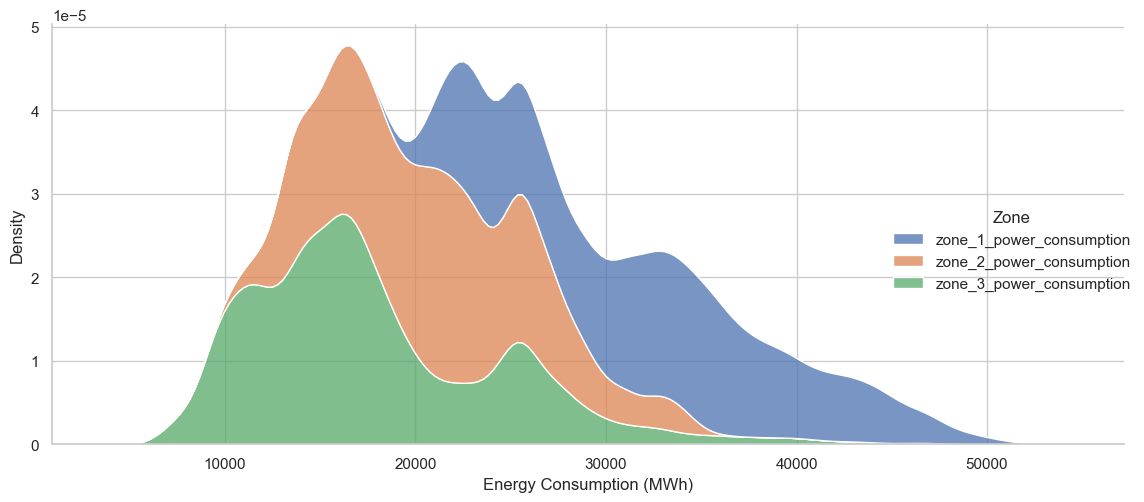

In [10]:
consumption_data_long = consumption_data.melt(
    var_name='Zone', value_name='Energy Consumption'
)
g = sns.displot(consumption_data_long, x="Energy Consumption", hue="Zone", kind="kde", height=6, aspect=1.5, multiple="stack")
g.set_axis_labels('Energy Consumption (MWh)', 'Density')
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.2)
plt.show()


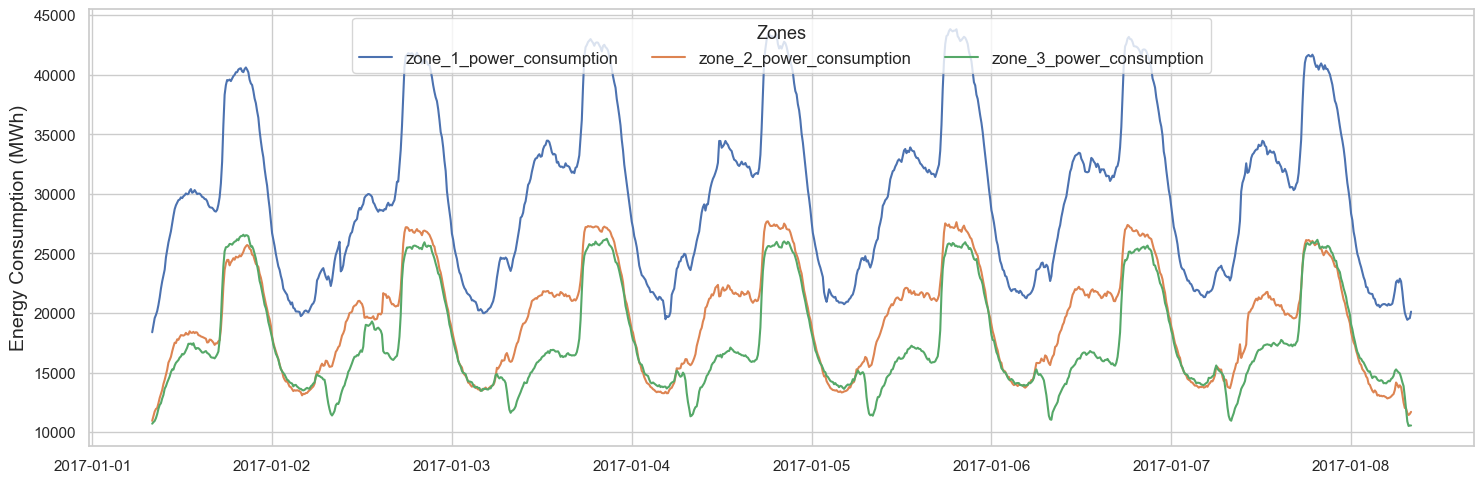

In [11]:
week_filtered_data = consumption_data.loc['2017-01-01 08:00':'2017-01-08 08:00']
plt.figure(figsize=(15, 5))
for i, col in enumerate(week_filtered_data.columns):
    plt.plot(week_filtered_data.index, week_filtered_data[col], label=col, color=sns.color_palette()[i])
plt.ylabel('Energy Consumption (MWh)', fontsize=14)
plt.legend(title='Zones', fontsize=12, title_fontsize='13', loc='upper center', ncol=3)
plt.tight_layout()
plt.show()


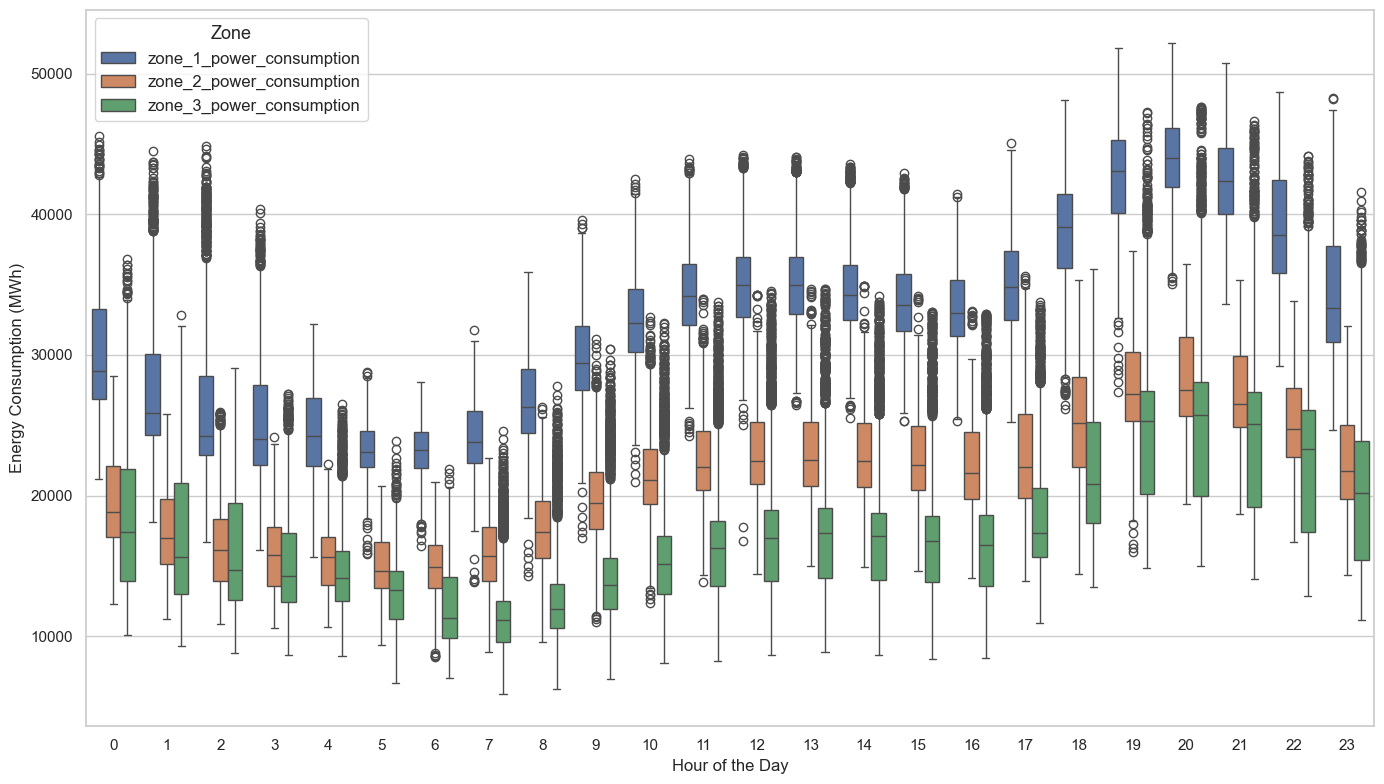

In [12]:
hour_melted_data = data.melt(
    id_vars=['hour'],
    value_vars=target,
    var_name='Zone', value_name='Power Consumption'
)
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=hour_melted_data, x='hour', y='Power Consumption', hue='Zone', ax=ax)
ax.set_xlabel('Hour of the Day', fontsize=12)
ax.set_ylabel('Energy Consumption (MWh)', fontsize=12)
ax.legend(title='Zone', fontsize=12, title_fontsize='13')
plt.tight_layout()
plt.show()


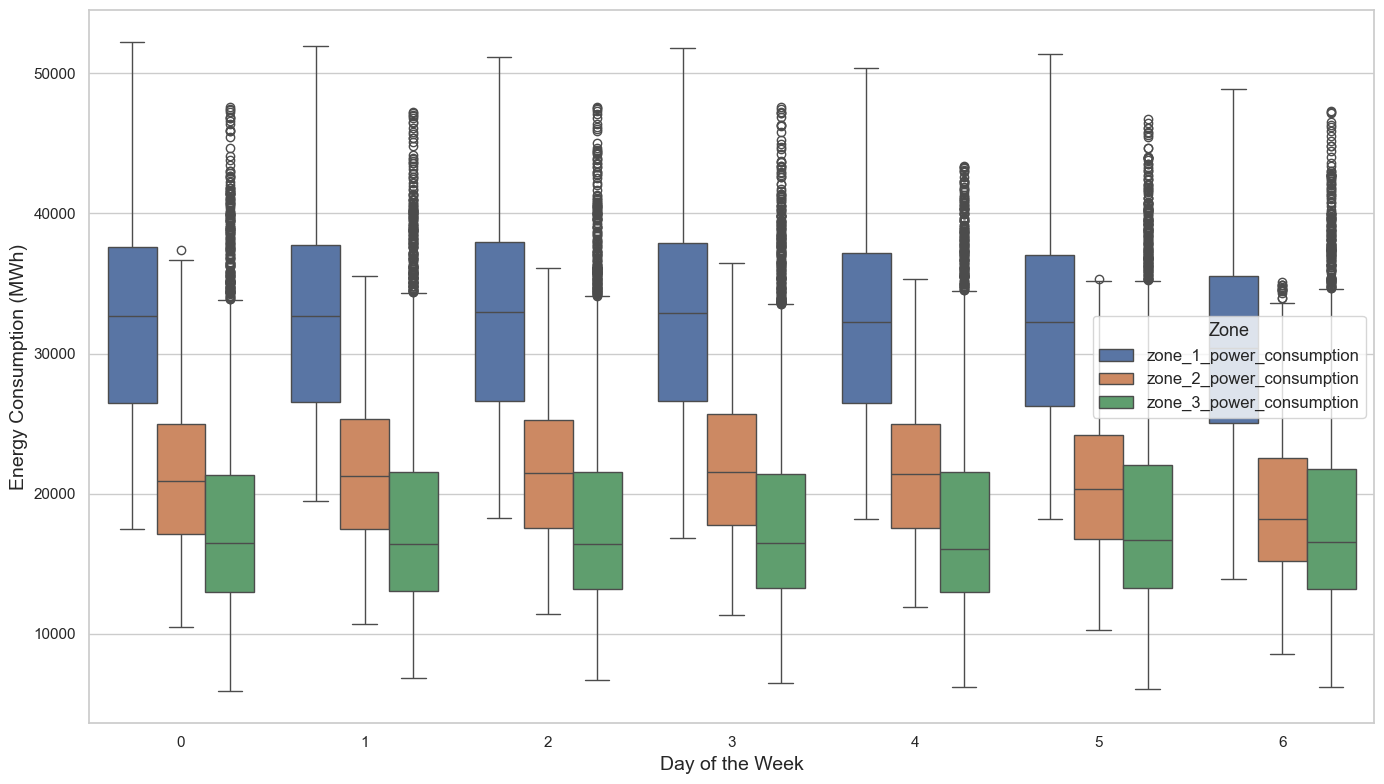

In [13]:
melted_data_dayofweek = data.melt(
    id_vars=['dayofweek'],
    value_vars=target,
    var_name='Zone', value_name='Power Consumption'
)
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=melted_data_dayofweek, x='dayofweek', y='Power Consumption', hue='Zone', ax=ax)
ax.set_xlabel('Day of the Week', fontsize=14)
ax.set_ylabel('Energy Consumption (MWh)', fontsize=14)
ax.legend(title='Zone', fontsize=12, title_fontsize='13')
plt.tight_layout()
plt.show()


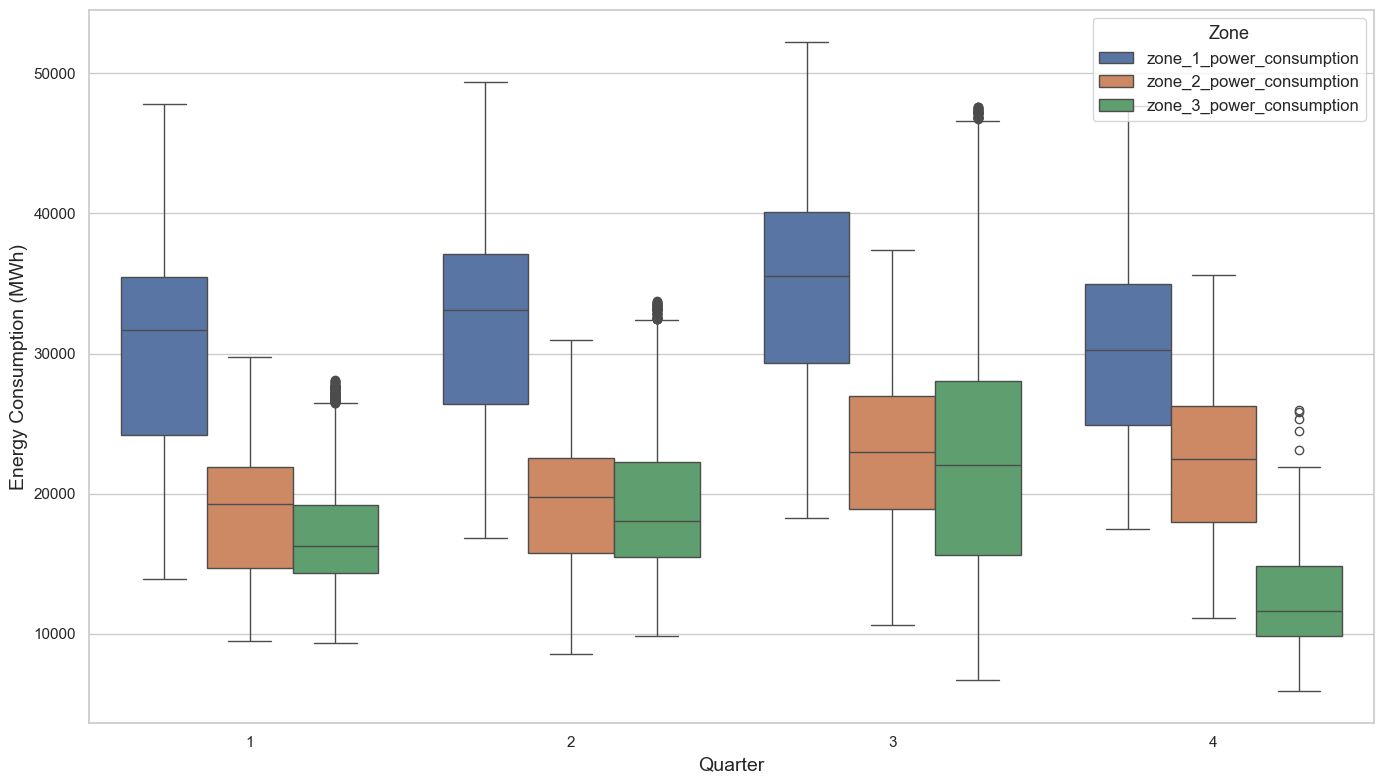

In [14]:
melted_data_quarter = data.melt(
    id_vars=['quarter'],
    value_vars=target,
    var_name='Zone', value_name='Power Consumption'
)
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=melted_data_quarter, x='quarter', y='Power Consumption', hue='Zone', ax=ax)
ax.set_xlabel('Quarter', fontsize=14)
ax.set_ylabel('Energy Consumption (MWh)', fontsize=14)
ax.legend(title='Zone', fontsize=12, title_fontsize='13')
plt.tight_layout()
plt.show()


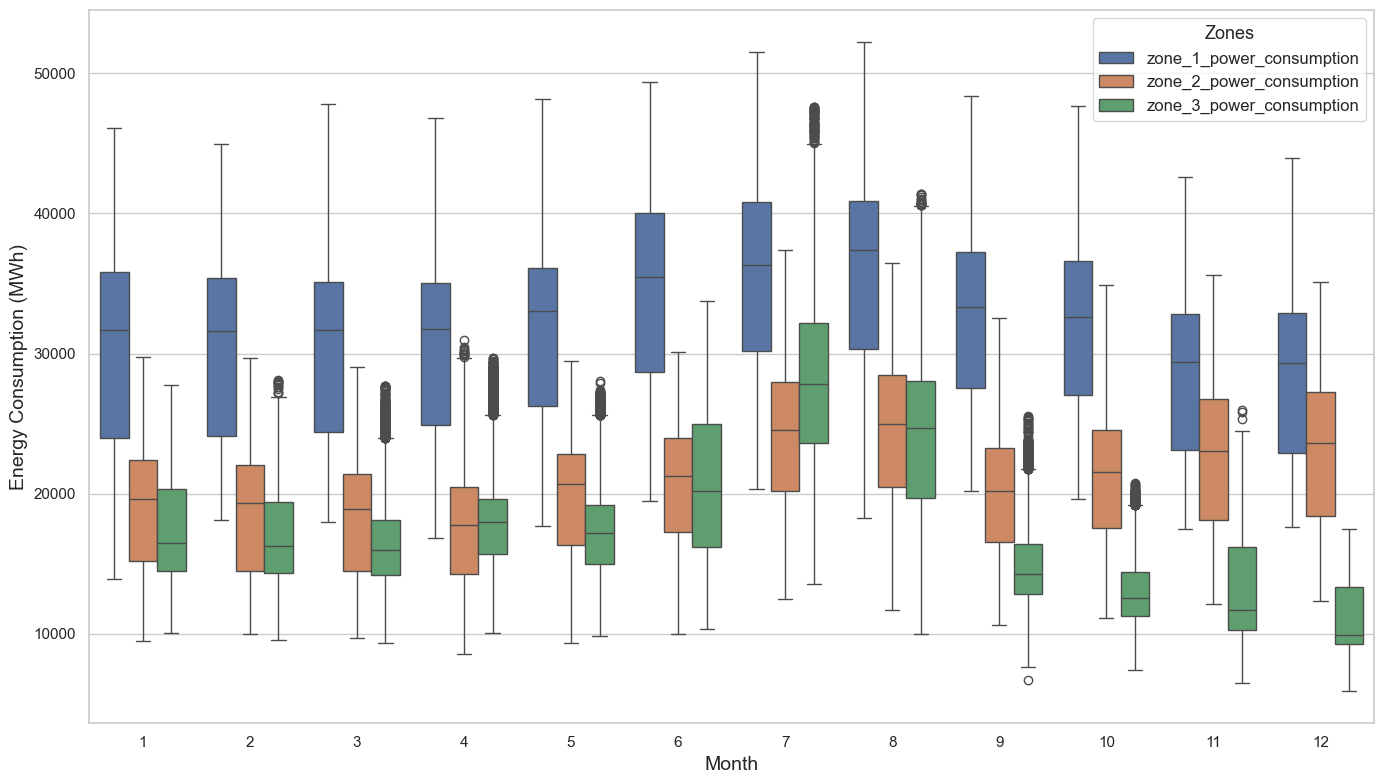

In [15]:
melted_data_month = data.melt(
    id_vars=['month'],
    value_vars=target,
    var_name='Zone', value_name='Power Consumption'
)
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=melted_data_month, x='month', y='Power Consumption', hue='Zone', ax=ax)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Energy Consumption (MWh)', fontsize=14)
ax.legend(title='Zones', fontsize=12, title_fontsize='13')
plt.tight_layout()
plt.show()


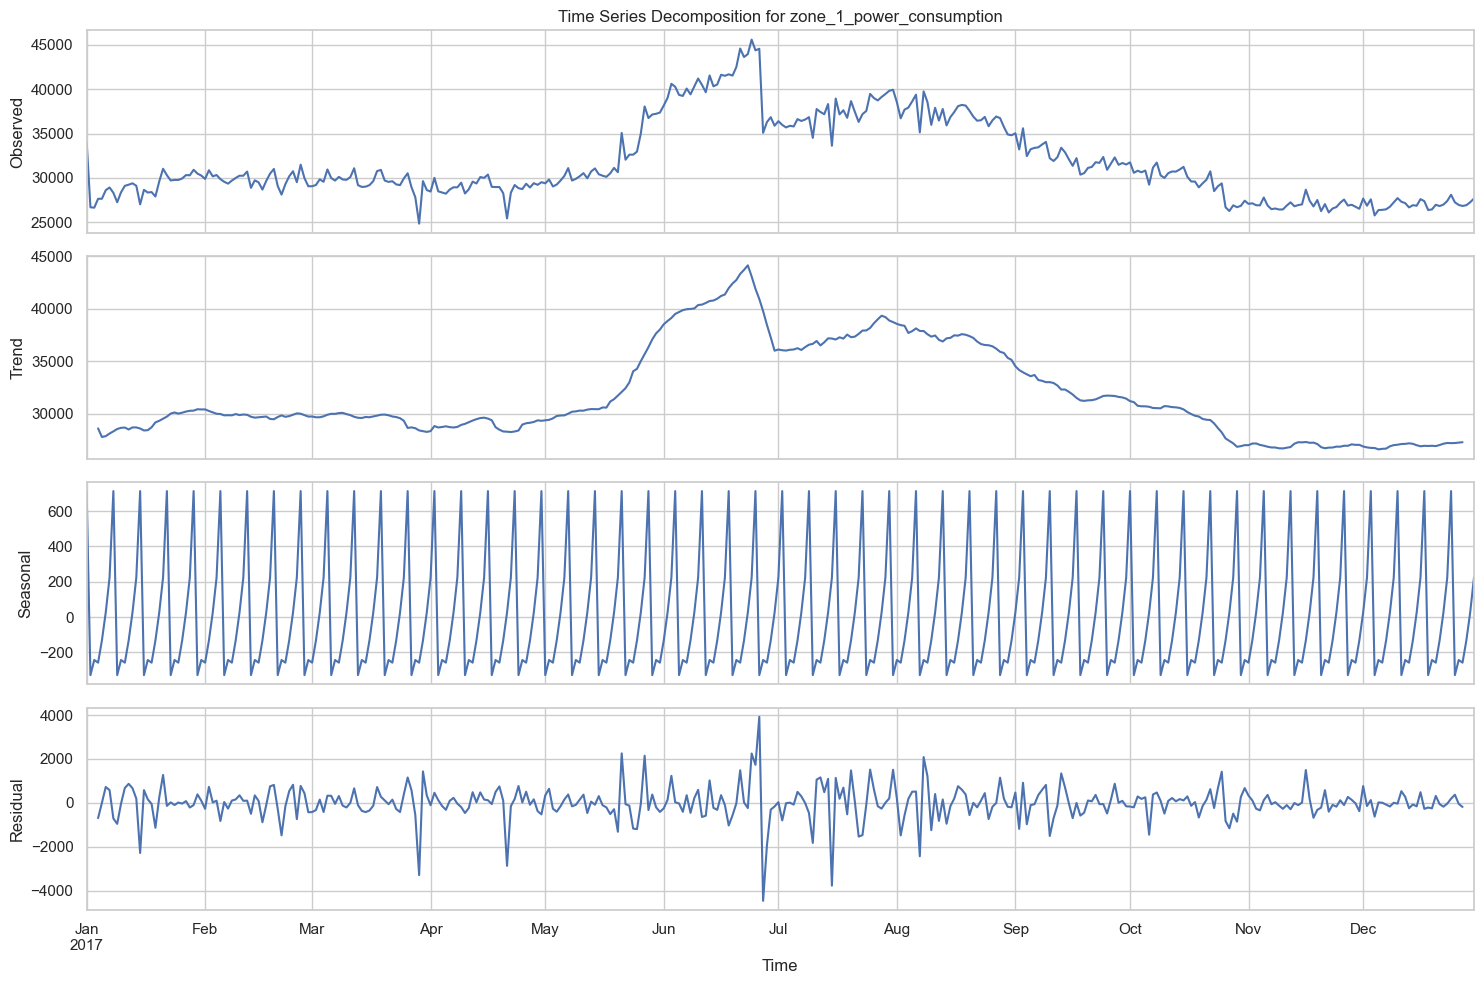

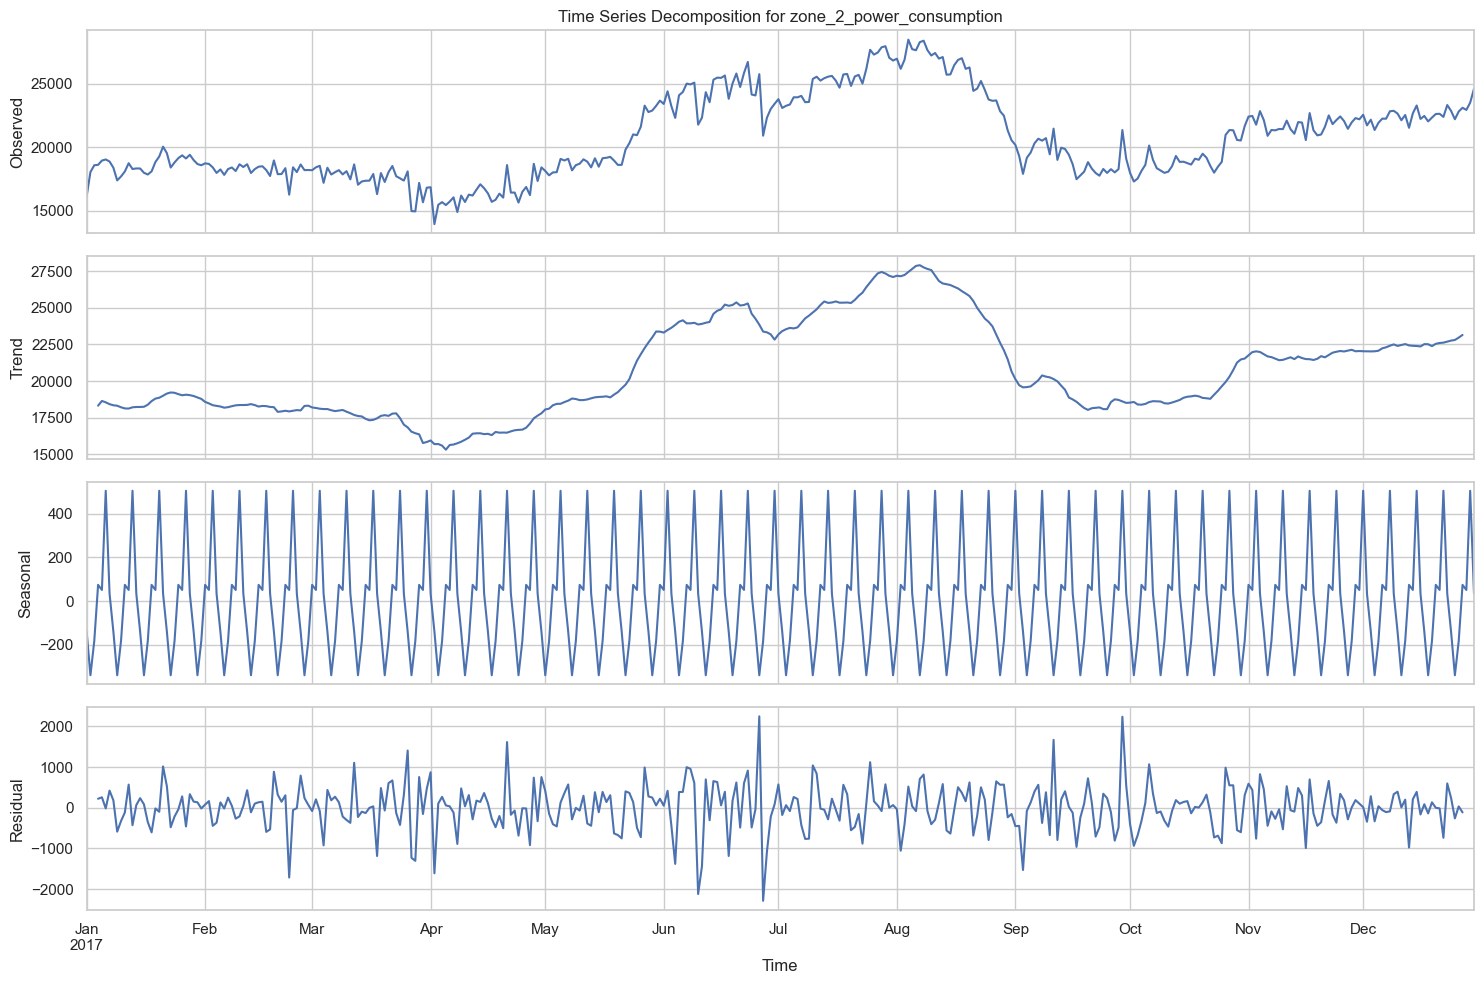

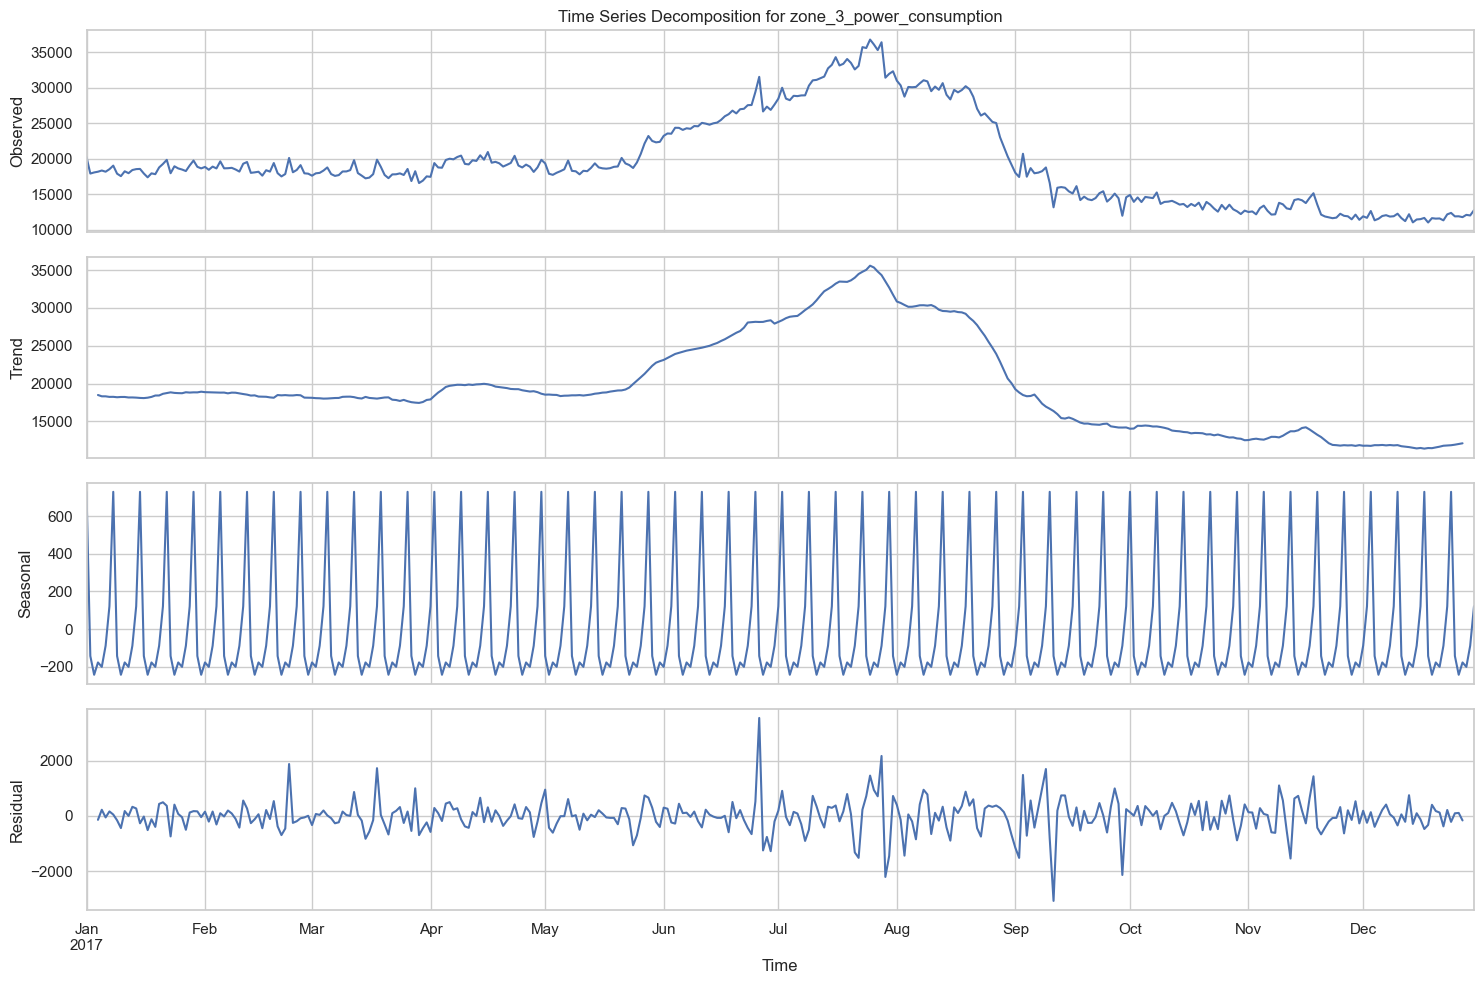

In [16]:
data_STD = data.asfreq('D')

for zone in target:
    decomposition = seasonal_decompose(data_STD[zone], model='additive')
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    decomposition.observed.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Observed')
    ax1.set_title(f'Time Series Decomposition for {zone}')
    
    decomposition.trend.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=ax4, legend=False)
    ax4.set_ylabel('Residual')
    ax4.set_xlabel('Time')
    
    plt.tight_layout()
    plt.show()


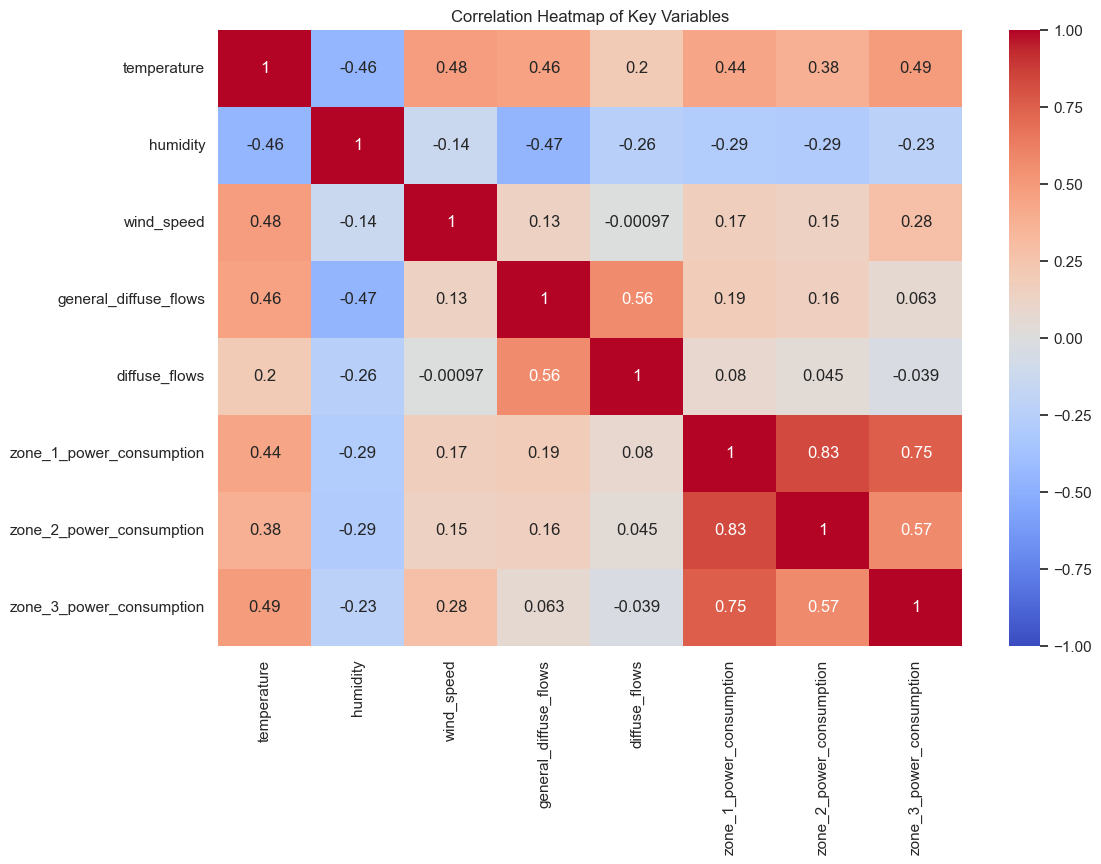

In [17]:
correlation_matrix = data_key_vars.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Key Variables')
plt.show()

In [18]:
data.columns

Index(['temperature', 'humidity', 'wind_speed', 'general_diffuse_flows',
       'diffuse_flows', 'zone_1_power_consumption', 'zone_2_power_consumption',
       'zone_3_power_consumption', 'hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'day', 'is_weekend',
       'zone_1_power_consumption_lag_1', 'zone_1_power_consumption_lag_2',
       'zone_1_power_consumption_rolling_mean_3',
       'zone_1_power_consumption_rolling_std_3',
       'zone_1_power_consumption_ema_3', 'zone_2_power_consumption_lag_1',
       'zone_2_power_consumption_lag_2',
       'zone_2_power_consumption_rolling_mean_3',
       'zone_2_power_consumption_rolling_std_3',
       'zone_2_power_consumption_ema_3', 'zone_3_power_consumption_lag_1',
       'zone_3_power_consumption_lag_2',
       'zone_3_power_consumption_rolling_mean_3',
       'zone_3_power_consumption_rolling_std_3',
       'zone_3_power_consumption_ema_3'],
      dtype='object')

# 4. MODELLING

## 4.1. Train and test split

In [19]:
train_size=0.7
train_index=int(len(data)*train_size)
train=data.iloc[:train_index]
test=data.iloc[train_index:]

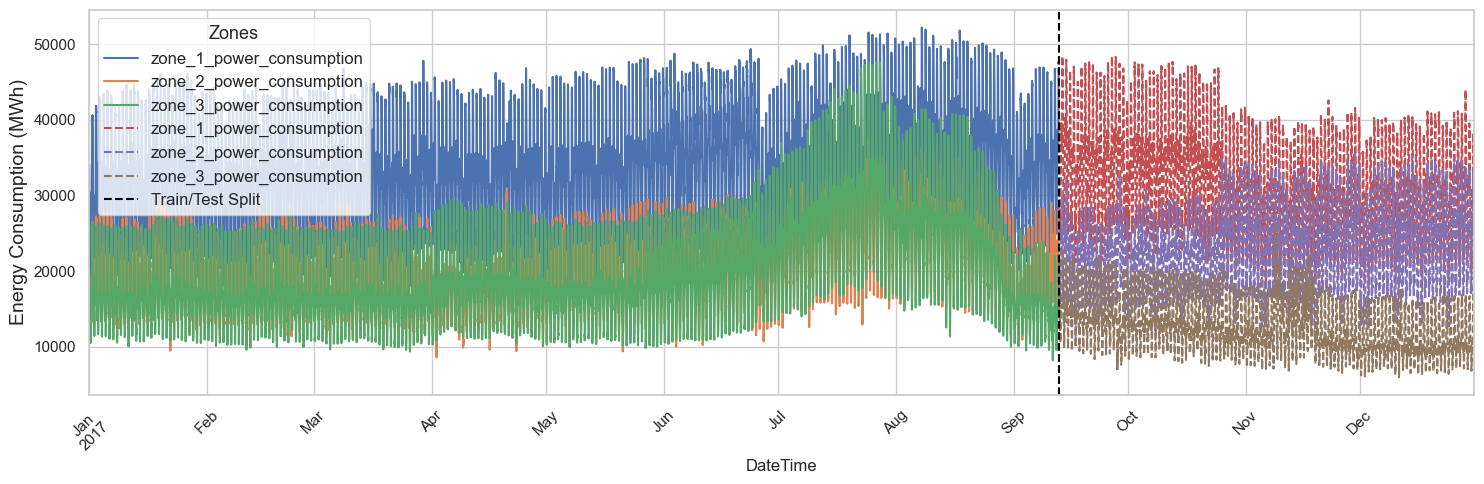

In [20]:

fig, ax = plt.subplots(figsize=(15, 5))
train[['zone_1_power_consumption', 'zone_2_power_consumption', 'zone_3_power_consumption']].plot(ax=ax, style='-', label=['Zone 1 (Training)', 'Zone 2 (Training)', 'Zone 3 (Training)'])
test[['zone_1_power_consumption', 'zone_2_power_consumption', 'zone_3_power_consumption']].plot(ax=ax, style='--', label=['Zone 1 (Test)', 'Zone 2 (Test)', 'Zone 3 (Test)'])
ax.axvline(data.index[train_index], color='black', ls='--', label='Train/Test Split')
ax.set_ylabel('Energy Consumption (MWh)', fontsize=14)
ax.legend(title='Zones', fontsize=12, title_fontsize='13')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
X_train=train[features]
y_train=train[target]

X_test=test[features]
y_test=test[target]

In [22]:
min_train_length = min(len(X_train), len(y_train))
X_train = X_train.iloc[:min_train_length]
y_train = y_train.iloc[:min_train_length]

min_test_length = min(len(X_test), len(y_test))
X_test = X_test.iloc[:min_test_length]
y_test = y_test.iloc[:min_test_length]

In [23]:
tscv = TimeSeriesSplit(n_splits=5)

## 4.2. Model Creation

### **4.2.1. XGBooster**

In [24]:
#Cross-Validation with Baseline Model
baseline_reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.002, 
)
cv_results = cross_val_score(baseline_reg, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
baseline_cv_rmse = np.sqrt(-cv_results.mean())
print(f'Baseline model cross-validated RMSE: {baseline_cv_rmse:.2f}')

#Baseline model training and evaluate on test set
baseline_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=100)
baseline_predictions = baseline_reg.predict(X_test)

baseline_rmse_xgb = {}
for i, target_name in enumerate(target):
    baseline_rmse_xgb[target_name] = np.sqrt(mean_squared_error(y_test[target_name], baseline_predictions[:, i] if baseline_predictions.ndim > 1 else baseline_predictions))
    print(f'Baseline RMSE for {target_name}: {baseline_rmse_xgb[target_name]:0.2f}')

Baseline model cross-validated RMSE: 1731.86
[0]	validation_0-rmse:9402.77757


/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:7736.22809
[200]	validation_0-rmse:6370.71852
[300]	validation_0-rmse:5251.50821
[400]	validation_0-rmse:4333.91683
[500]	validation_0-rmse:3581.72863
[600]	validation_0-rmse:2965.89032
[700]	validation_0-rmse:2463.58798
[800]	validation_0-rmse:2052.55780
[900]	validation_0-rmse:1716.88869
[999]	validation_0-rmse:1444.18912
Baseline RMSE for zone_1_power_consumption: 1301.09
Baseline RMSE for zone_2_power_consumption: 775.18
Baseline RMSE for zone_3_power_consumption: 1990.80


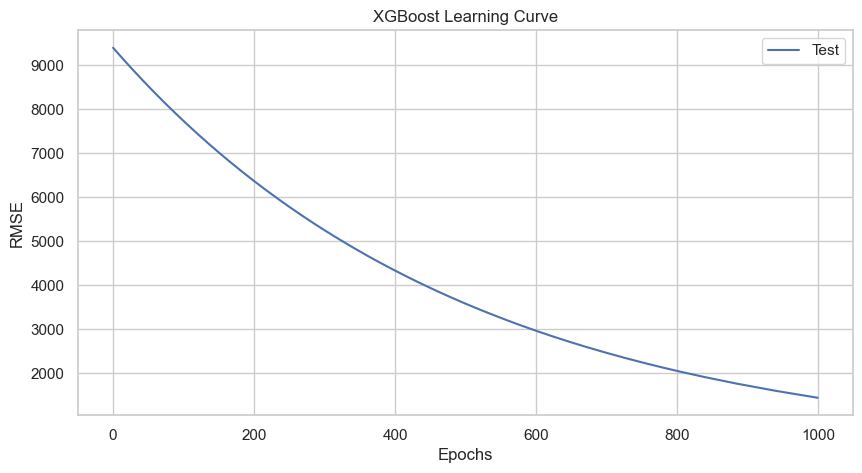

In [25]:
# Plot the learning curve
evals_result = baseline_reg.evals_result()

# Extract the train and evaluation results
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_axis, evals_result['validation_0']['rmse'], label='Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')
ax.set_title('XGBoost Learning Curve')
ax.legend()
plt.show()

In [26]:
#Hyperparameter Tuning with RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(),
    param_distributions=param_grid,
    n_iter=20,  
    scoring='neg_mean_squared_error',
    cv=3,  
    verbose=1,
    random_state=42,
    n_jobs=1  
)

random_search.fit(X_train, y_train)
best_reg = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [27]:
#Evaluate tuned Model with Cross-Validation
cv_rmse_scores = []
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    best_reg.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=50, verbose=100)
    
    val_predictions = best_reg.predict(X_val_fold)
    val_rmse = np.sqrt(mean_squared_error(y_val_fold, val_predictions))
    cv_rmse_scores.append(val_rmse)

tuned_cv_rmse_xgb = np.mean(cv_rmse_scores)
print(f'Tuned model cross-validated RMSE: {tuned_cv_rmse_xgb:.2f}')

[0]	validation_0-rmse:7403.06731


/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:180.24703
[200]	validation_0-rmse:174.32196
[300]	validation_0-rmse:171.16342
[400]	validation_0-rmse:169.65217
[499]	validation_0-rmse:168.42854
[0]	validation_0-rmse:7218.89575


/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:250.43844
[200]	validation_0-rmse:244.07380
[300]	validation_0-rmse:240.62233
[400]	validation_0-rmse:237.38798
[499]	validation_0-rmse:236.32442
[0]	validation_0-rmse:8045.88244


/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:293.21371
[200]	validation_0-rmse:279.12198
[300]	validation_0-rmse:273.05778
[400]	validation_0-rmse:270.34940
[499]	validation_0-rmse:268.19219
[0]	validation_0-rmse:9105.64145


/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:2445.32731
[182]	validation_0-rmse:2456.57571
[0]	validation_0-rmse:8451.15307


/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:233.10460
[200]	validation_0-rmse:225.50975
[300]	validation_0-rmse:223.76999
[400]	validation_0-rmse:222.67817
[499]	validation_0-rmse:221.76667
Tuned model cross-validated RMSE: 667.56


In [28]:
# Evaluate the tuned model on the test set
tuned_predictions = best_reg.predict(X_test)

tuned_rmse_xgb = {}
for i, target_name in enumerate(target):
    tuned_rmse_xgb[target_name] = np.sqrt(mean_squared_error(y_test[target_name], tuned_predictions[:, i] if tuned_predictions.ndim > 1 else tuned_predictions))
    print(f'Tuned RMSE for {target_name}: {tuned_rmse_xgb[target_name]:0.2f}')


# Comparison of Baseline and Tuned RMSE
for target_name in target:
    baseline = baseline_rmse_xgb[target_name]
    tuned = tuned_rmse_xgb[target_name]
    improvement = baseline - tuned
    print(f'{target_name} - Baseline RMSE: {baseline:0.2f}, Tuned RMSE: {tuned:0.2f}')
    print(f'Improvement in RMSE for {target_name}: {improvement:0.2f}')

Tuned RMSE for zone_1_power_consumption: 384.43
Tuned RMSE for zone_2_power_consumption: 250.65
Tuned RMSE for zone_3_power_consumption: 752.83
zone_1_power_consumption - Baseline RMSE: 1301.09, Tuned RMSE: 384.43
Improvement in RMSE for zone_1_power_consumption: 916.66
zone_2_power_consumption - Baseline RMSE: 775.18, Tuned RMSE: 250.65
Improvement in RMSE for zone_2_power_consumption: 524.53
zone_3_power_consumption - Baseline RMSE: 1990.80, Tuned RMSE: 752.83
Improvement in RMSE for zone_3_power_consumption: 1237.97


In [29]:
model_path = os.path.join(output_dir, 'best_xgb_model.pkl')
joblib.dump(best_reg, model_path)

['/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/ADA_FP/best_xgb_model.pkl']

### **4.2.2. Random Forrest Regressor**

In [30]:
# Baseline of the model
baseline_rf = RandomForestRegressor(random_state=42)
baseline_rf.fit(X_train, y_train)
baseline_predictions_rf = baseline_rf.predict(X_test)

baseline_rmse_rf = {}
for i, target_name in enumerate(target):
    baseline_rmse_rf[target_name] = np.sqrt(mean_squared_error(y_test[target_name], baseline_predictions_rf[:, i]))
    print(f'Baseline Random Forest RMSE for {target_name}: {baseline_rmse_rf[target_name]:0.2f}')

Baseline Random Forest RMSE for zone_1_power_consumption: 758.43
Baseline Random Forest RMSE for zone_2_power_consumption: 3021.85
Baseline Random Forest RMSE for zone_3_power_consumption: 1533.64


In [31]:
#Consider take 24-27 min to run
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=20, 
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1 
)

random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_
print(f"Best parameters from RandomizedSearchCV: {random_search_rf.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  37.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  38.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  38.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  33.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  34.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  35.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  45.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500

In [32]:
#Consider take 19-20 min to run
# Fine-tuning the model
param_grid_fine = {
    'n_estimators': [best_rf.n_estimators - 10, best_rf.n_estimators, best_rf.n_estimators + 10],
    'max_depth': [best_rf.max_depth - 2, best_rf.max_depth, best_rf.max_depth + 2],
    'min_samples_split': [best_rf.min_samples_split - 1, best_rf.min_samples_split, best_rf.min_samples_split + 1],
    'min_samples_leaf': [best_rf.min_samples_leaf - 1, best_rf.min_samples_leaf, best_rf.min_samples_leaf + 1],
    'max_features': [best_rf.max_features]
}

param_grid_fine = {k: [v for v in values if v is not None] for k, values in param_grid_fine.items()}

grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_fine,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1 
)

grid_search_rf.fit(X_train, y_train)

best_rf_fine = grid_search_rf.best_estimator_
print(f"Best parameters from GridSearchCV: {grid_search_rf.best_params_}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=0, min_samples_split=1, n_estimators=310; total time=   0.0s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=0, min_samples_split=1, n_estimators=300; total time=   0.0s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=0, min_samples_split=1, n_estimators=290; total time=   0.0s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=0, min_samples_split=1, n_estimators=300; total time=   0.1s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=0, min_samples_split=1, n_estimators=310; total time=   0.1s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=0, min_samples_split=1, n_estimators=290; total time=   0.0s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=0, min_samples_split=1, n_estimators=290; total time=   0.1s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=0, min_samples_split=1, n_estimators=30

/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=310; total time= 1.4min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=310; total time= 1.4min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=290; total time= 1.3min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=290; total time= 1.3min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=290; total time= 1.3min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=290; total time=   0.0s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=290; total time=   0.0s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=290; total time=   0.1s
[CV] END max_depth=18, max_features=sqrt

/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
135 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File 

Best parameters from GridSearchCV: {'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 290}


In [34]:
cv_rmse_scores_rf = []

for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    best_rf_fine.fit(X_train_fold, y_train_fold)
    
    val_predictions = best_rf_fine.predict(X_val_fold)
    val_rmse = np.sqrt(mean_squared_error(y_val_fold, val_predictions))
    cv_rmse_scores_rf.append(val_rmse)

tuned_cv_rf_rmse = np.mean(cv_rmse_scores_rf)
print(f'Tuned Random Forest model cross-validated RMSE: {tuned_cv_rf_rmse:.2f}')

best_rf_fine.fit(X_train, y_train)

rf_predictions = best_rf_fine.predict(X_test)

if rf_predictions.ndim == 1:
    rf_predictions = rf_predictions.reshape(-1, 1)

if rf_predictions.shape[1] == 1:
    rf_predictions = np.tile(rf_predictions, (1, len(target)))

tuned_rmse_rf = {}
for i, target_name in enumerate(target):
    tuned_rmse_rf[target_name] = np.sqrt(mean_squared_error(y_test[target_name], rf_predictions[:, i]))
    print(f'Tuned Random Forest RMSE for {target_name}: {tuned_rmse_rf[target_name]:0.2f}')

for target_name in target:
    print(f'{target_name} - Baseline RMSE: {baseline_rmse_rf[target_name]:0.2f}, Tuned RMSE: {tuned_rmse_rf[target_name]:0.2f}')
    improvement = baseline_rmse_rf[target_name] - tuned_rmse_rf[target_name]
    print(f'Improvement in RMSE for {target_name}: {improvement:0.2f}')

Tuned Random Forest model cross-validated RMSE: 1168.63
Tuned Random Forest RMSE for zone_1_power_consumption: 911.48
Tuned Random Forest RMSE for zone_2_power_consumption: 2610.25
Tuned Random Forest RMSE for zone_3_power_consumption: 1887.58
zone_1_power_consumption - Baseline RMSE: 758.43, Tuned RMSE: 911.48
Improvement in RMSE for zone_1_power_consumption: -153.06
zone_2_power_consumption - Baseline RMSE: 3021.85, Tuned RMSE: 2610.25
Improvement in RMSE for zone_2_power_consumption: 411.60
zone_3_power_consumption - Baseline RMSE: 1533.64, Tuned RMSE: 1887.58
Improvement in RMSE for zone_3_power_consumption: -353.94


### **4.2.3. LSTM**

In [35]:
print(X_train.isna().sum())
print(y_train.isna().sum())

temperature                                0
humidity                                   0
wind_speed                                 0
general_diffuse_flows                      0
diffuse_flows                              0
hour                                       0
dayofweek                                  0
quarter                                    0
month                                      0
year                                       0
dayofyear                                  0
day                                        0
is_weekend                                 0
zone_1_power_consumption_lag_1             1
zone_1_power_consumption_lag_2             2
zone_1_power_consumption_rolling_mean_3    2
zone_1_power_consumption_rolling_std_3     2
zone_1_power_consumption_ema_3             0
zone_2_power_consumption_lag_1             1
zone_2_power_consumption_lag_2             2
zone_2_power_consumption_rolling_mean_3    2
zone_2_power_consumption_rolling_std_3     2
zone_2_pow

In [36]:
X_train = X_train.fillna(X_train.mean())
y_train = y_train.fillna(y_train.mean())
X_test = X_test.fillna(X_test.mean())
y_test = y_test.fillna(y_test.mean())

In [37]:
already_scaled = ['temperature', 'humidity', 'wind_speed', 'general_diffuse_flows', 'diffuse_flows']
to_scale = ['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'day', 'zone_1_power_consumption_lag_1',
            'zone_1_power_consumption_lag_2',
            'zone_1_power_consumption_rolling_mean_3',
            'zone_1_power_consumption_rolling_std_3',
            'zone_1_power_consumption_ema_3', 'zone_2_power_consumption_lag_1',
            'zone_2_power_consumption_lag_2',
            'zone_2_power_consumption_rolling_mean_3',
            'zone_2_power_consumption_rolling_std_3',
            'zone_2_power_consumption_ema_3', 'zone_3_power_consumption_lag_1',
            'zone_3_power_consumption_lag_2',
            'zone_3_power_consumption_rolling_mean_3',
            'zone_3_power_consumption_rolling_std_3',
            'zone_3_power_consumption_ema_3']

In [38]:
#Re scale all the others columns of the model. Consider before we just scale 5 variables.
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[to_scale] = scaler_X.fit_transform(X_train[to_scale])
X_test_scaled[to_scale] = scaler_X.transform(X_test[to_scale])

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [39]:
def create_sequences(X, y, time_steps=20):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

time_steps = 20

if len(X_train_scaled) > time_steps and len(y_train_scaled) > time_steps:
    X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled, time_steps)
else:
    raise ValueError("Not enough training samples to create sequences with the given time_steps")

if len(X_test_scaled) > time_steps and len(y_test_scaled) > time_steps:
    X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test_scaled, time_steps)
else:
    raise ValueError("Not enough test samples to create sequences with the given time_steps")

def check_and_handle_nan(arr):
    if np.isnan(arr).any():
        raise ValueError("Input contains NaN. Please handle missing values before proceeding.")
    return arr

In [40]:
lstm_model = Sequential()
lstm_model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), kernel_regularizer=l2(0.001)))
lstm_model.add(LSTM(64, activation='relu', kernel_regularizer=l2(0.001)))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(y_train_lstm.shape[1] if len(y_train_lstm.shape) > 1 else 1))
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,243 (508.76 KB)

 Trainable params: 130,115 (508.26 KB)

 Non-trainable params: 128 (512.00 B)

In [42]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
]

In [63]:
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=callbacks,
    verbose=2
)

lstm_predictions_scaled = lstm_model.predict(X_test_lstm)

Epoch 1/50
573/573 - 17s - 31ms/step - loss: 0.0022 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 2/50
573/573 - 17s - 29ms/step - loss: 0.0021 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 3/50
573/573 - 17s - 30ms/step - loss: 0.0021 - val_loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 4/50
573/573 - 16s - 28ms/step - loss: 0.0021 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 5/50
573/573 - 16s - 28ms/step - loss: 0.0021 - val_loss: 0.0084 - learning_rate: 1.0000e-04
Epoch 6/50
573/573 - 16s - 28ms/step - loss: 0.0020 - val_loss: 0.0029 - learning_rate: 1.0000e-04
Epoch 7/50
573/573 - 20s - 34ms/step - loss: 0.0019 - val_loss: 0.0286 - learning_rate: 1.0000e-04
Epoch 8/50
573/573 - 16s - 29ms/step - loss: 0.0018 - val_loss: 0.0030 - learning_rate: 1.0000e-04
Epoch 9/50
573/573 - 17s - 29ms/step - loss: 0.0017 - val_loss: 0.0262 - learning_rate: 1.0000e-04
Epoch 10/50
573/573 - 16s - 28ms/step - loss: 0.0017 - val_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 11/

In [64]:
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)

lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled)
y_test_lstm_original = scaler_y.inverse_transform(y_test_lstm)

lstm_rmse = {}
if y_test_lstm_original.ndim > 1 and y_test_lstm_original.shape[1] > 1:
    for i, target_name in enumerate(target):
        lstm_rmse[target_name] = np.sqrt(mean_squared_error(y_test_lstm_original[:, i], lstm_predictions[:, i]))
        print(f'LSTM RMSE for {target_name}: {lstm_rmse[target_name]:0.2f}')
else:
    lstm_rmse[target[0]] = np.sqrt(mean_squared_error(y_test_lstm_original, lstm_predictions))
    print(f'LSTM RMSE for {target[0]}: {lstm_rmse[target[0]]:0.2f}')

491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
LSTM RMSE for zone_1_power_consumption: 864.41
LSTM RMSE for zone_2_power_consumption: 1117.61
LSTM RMSE for zone_3_power_consumption: 958.32


# 5. EVALUATION AND VISUALIZATION

In [65]:
# RMSE results for XGBoost
xgboost_rmse_baseline = {
    'zone_1_power_consumption': baseline_rmse_xgb['zone_1_power_consumption'],
    'zone_2_power_consumption': baseline_rmse_xgb['zone_2_power_consumption'],
    'zone_3_power_consumption': baseline_rmse_xgb['zone_3_power_consumption']
}

xgboost_rmse_tuned = {
    'zone_1_power_consumption': tuned_rmse_xgb['zone_1_power_consumption'],
    'zone_2_power_consumption': tuned_rmse_xgb['zone_2_power_consumption'],
    'zone_3_power_consumption': tuned_rmse_xgb['zone_3_power_consumption']
}

# RMSE results for Random Forest
random_forest_rmse_baseline = {
    'zone_1_power_consumption': baseline_rmse_rf['zone_1_power_consumption'],
    'zone_2_power_consumption': baseline_rmse_rf['zone_2_power_consumption'],
    'zone_3_power_consumption': baseline_rmse_rf['zone_3_power_consumption']
}

random_forest_rmse_tuned = {
    'zone_1_power_consumption': tuned_rmse_rf['zone_1_power_consumption'],
    'zone_2_power_consumption': tuned_rmse_rf['zone_2_power_consumption'],
    'zone_3_power_consumption': tuned_rmse_rf['zone_3_power_consumption']
}

# RMSE results for LSTM
lstm_rmse_results = {
    'zone_1_power_consumption': lstm_rmse['zone_1_power_consumption'],
    'zone_2_power_consumption': lstm_rmse['zone_2_power_consumption'],
    'zone_3_power_consumption': lstm_rmse['zone_3_power_consumption']
}

rmse_summary = pd.DataFrame({
    'XGBoost Baseline': xgboost_rmse_baseline,
    'XGBoost Tuned': xgboost_rmse_tuned,
    'Random Forest Baseline': random_forest_rmse_baseline,
    'Random Forest Tuned': random_forest_rmse_tuned,
    'LSTM': lstm_rmse_results
})

print("RMSE Summary for Different Models")
print(rmse_summary)


RMSE Summary for Different Models
                          XGBoost Baseline  XGBoost Tuned  \
zone_1_power_consumption       1301.091975     384.432398   
zone_2_power_consumption        775.181382     250.651122   
zone_3_power_consumption       1990.803890     752.829419   

                          Random Forest Baseline  Random Forest Tuned  \
zone_1_power_consumption              758.426814           911.481999   
zone_2_power_consumption             3021.850181          2610.249135   
zone_3_power_consumption             1533.642919          1887.584379   

                                 LSTM  
zone_1_power_consumption   864.414673  
zone_2_power_consumption  1117.612915  
zone_3_power_consumption   958.315186  


In [66]:
#EVALUATING THE XGBOOST
comparison_df = X_test.copy()
for i, target_name in enumerate(target):
    comparison_df[f'actual_{target_name}'] = y_test[target_name]
    comparison_df[f'predicted_{target_name}'] = tuned_predictions[:, i] if tuned_predictions.ndim > 1 else tuned_predictions

comparison_df['date'] = test.index

cols = ['date']
for target_name in target:
    cols.append(f'actual_{target_name}')
    cols.append(f'predicted_{target_name}')

comparison_df = comparison_df[cols]

print(comparison_df.head())

comparison_df.to_csv('comparison_actual_vs_predicted.csv', index=False)

                                   date  actual_zone_1_power_consumption  \
DateTime                                                                   
2017-09-12 19:10:00 2017-09-12 19:10:00                      47322.47788   
2017-09-12 19:20:00 2017-09-12 19:20:00                      47736.63717   
2017-09-12 19:30:00 2017-09-12 19:30:00                      47723.89381   
2017-09-12 19:40:00 2017-09-12 19:40:00                      47679.29204   
2017-09-12 19:50:00 2017-09-12 19:50:00                      47475.39823   

                     predicted_zone_1_power_consumption  \
DateTime                                                  
2017-09-12 19:10:00                        47516.871094   
2017-09-12 19:20:00                        47936.109375   
2017-09-12 19:30:00                        47890.062500   
2017-09-12 19:40:00                        47794.101562   
2017-09-12 19:50:00                        47521.859375   

                     actual_zone_2_power_consumption 

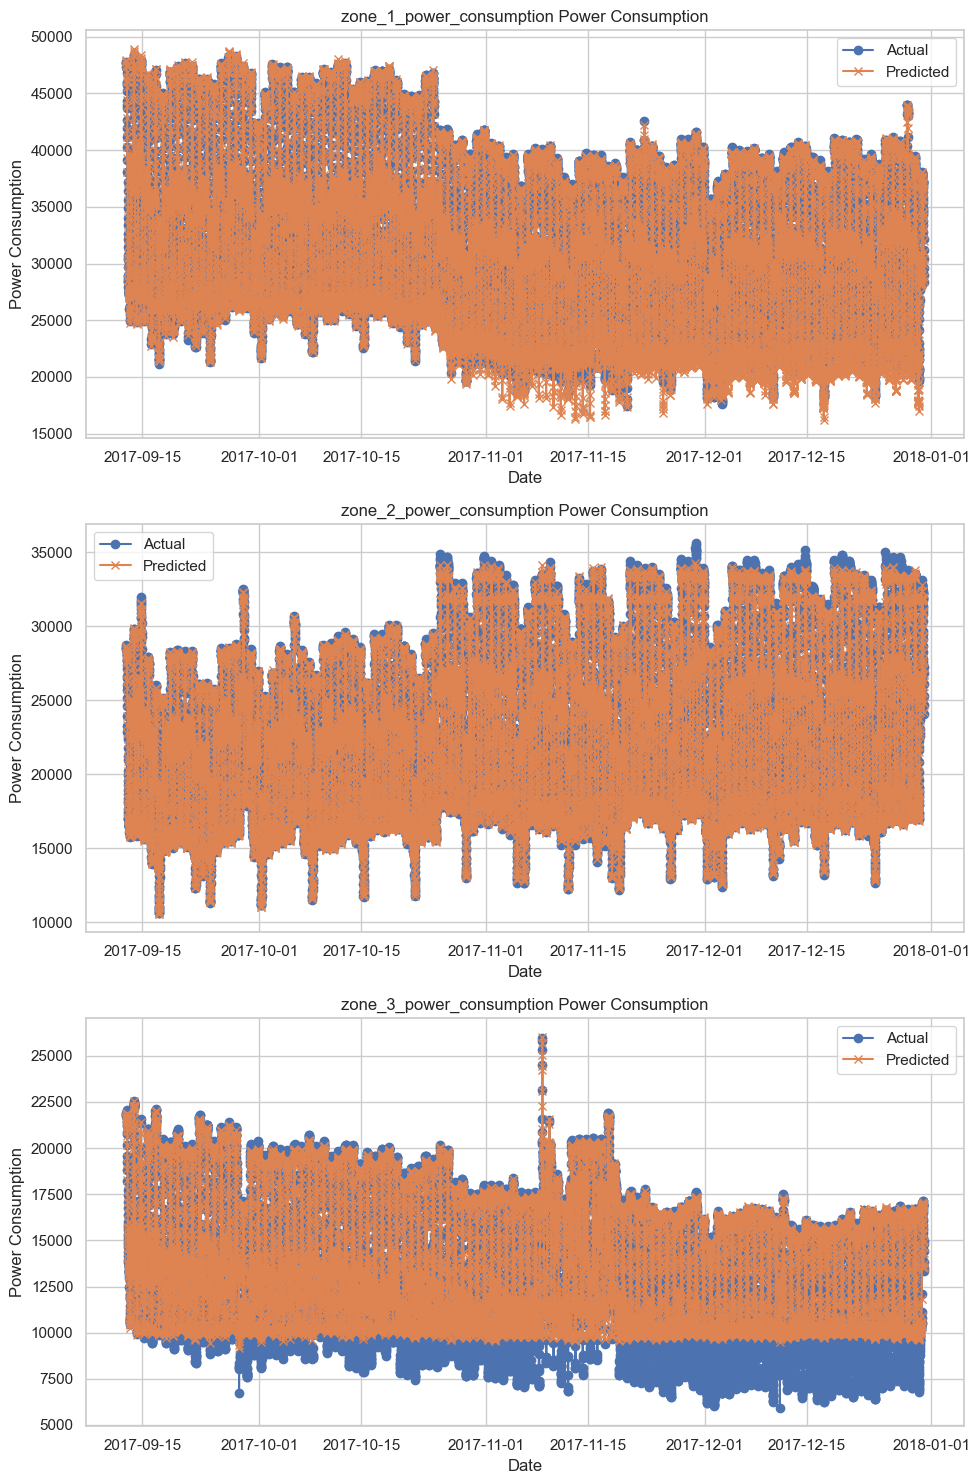

In [67]:
# Plot actual vs predicted values for each zone
fig, axes = plt.subplots(len(target), 1, figsize=(10, 15))

for i, target_name in enumerate(target):
    axes[i].plot(comparison_df['date'], comparison_df[f'actual_{target_name}'], label='Actual', marker='o')
    axes[i].plot(comparison_df['date'], comparison_df[f'predicted_{target_name}'], label='Predicted', marker='x')
    axes[i].set_title(f'{target_name} Power Consumption')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Power Consumption')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [68]:
model_path = os.path.join(output_dir, 'best_xgb_model.pkl')
joblib.dump(best_reg, model_path)

['/Users/fernandacladeramelgar/Documents/Projects/ADA_AP_FinalProject/ADA_FP/best_xgb_model.pkl']